In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor, Lasso, Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, learning_curve 
from sklearn.metrics import mean_squared_error
#pandas option to display max columns
pd.set_option('display.max_columns',None)
# Set Matplotlib defaults Style
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10
    )
sns.set_palette('plasma', n_colors=None, desat=None, color_codes=False)
import warnings
warnings.simplefilter("ignore")

# ETL

In [2]:
df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
print("train data : {}".format(df.shape))
print("test data : {}".format(df_test.shape))
df.head()

train data : (188533, 13)
test data : (125690, 12)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [3]:
test_ids = df_test['id'].copy()
df_test.drop("id",axis=1, inplace=True)
df.drop("id",axis=1, inplace=True)
df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [4]:
df.duplicated().sum()

0

In [5]:
#% of null by colums abs
(df.isnull().sum())/df.shape[0]*100

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

In [6]:
df['clean_title'].fillna('Unknown', inplace=True)
df_test['clean_title'].fillna('Unknown', inplace=True)

In [7]:
df['fuel_type'] = df.groupby(['model', 'model_year'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df_test['fuel_type'] = df_test.groupby(['model', 'model_year'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [8]:
df['accident'] = df.groupby(['model', 'model_year'])['accident'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
df_test['accident'] = df_test.groupby(['model', 'model_year'])['accident'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

# EDA

In [9]:
decrib_ob=pd.DataFrame(df.describe(include='O').T)
print(tabulate(decrib_ob, headers = 'keys', tablefmt = 'psql'))

+--------------+---------+----------+----------------------------------------------+--------+
|              |   count |   unique | top                                          |   freq |
|--------------+---------+----------+----------------------------------------------+--------|
| brand        |  188533 |       57 | Ford                                         |  23088 |
| model        |  188533 |     1897 | F-150 XLT                                    |   2945 |
| fuel_type    |  188533 |        8 | Gasoline                                     | 170142 |
| engine       |  188533 |     1117 | 355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel |   3462 |
| transmission |  188533 |       52 | A/T                                          |  49904 |
| ext_col      |  188533 |      319 | Black                                        |  48658 |
| int_col      |  188533 |      156 | Black                                        | 107674 |
| accident     |  188533 |        3 | None reported         

In [10]:
decrib_ob=pd.DataFrame(df.describe().T)
print(tabulate(decrib_ob, headers = 'keys', tablefmt = 'psql'))

+------------+---------+----------+-------------+-------+-------+-------+-------+------------------+
|            |   count |     mean |         std |   min |   25% |   50% |   75% |              max |
|------------+---------+----------+-------------+-------+-------+-------+-------+------------------|
| model_year |  188533 |  2015.83 |     5.66097 |  1974 |  2013 |  2017 |  2020 |   2024           |
| milage     |  188533 | 65705.3  | 49798.2     |   100 | 24115 | 57785 | 95400 | 405000           |
| price      |  188533 | 43878    | 78819.5     |  2000 | 17000 | 30825 | 49900 |      2.95408e+06 |
+------------+---------+----------+-------------+-------+-------+-------+-------+------------------+


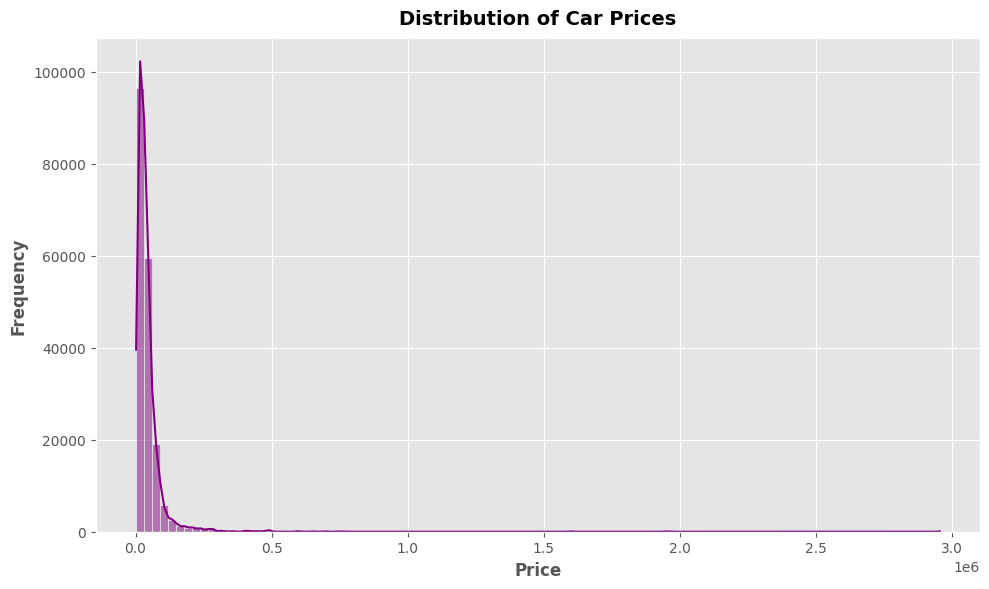

In [11]:
# Distribution of car prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=100, color='purple')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


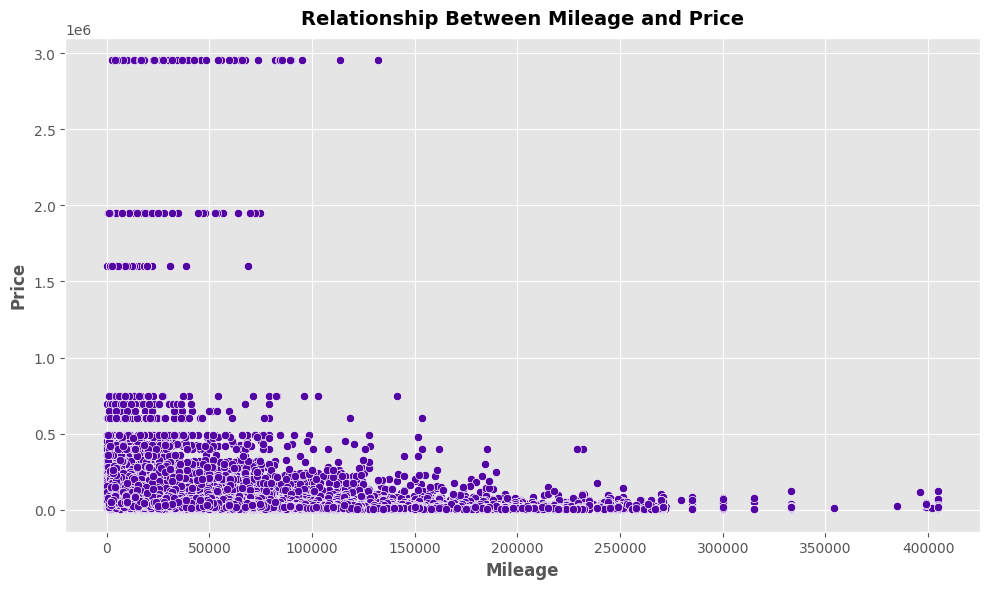

In [12]:
# Scatter plot of mileage vs price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['milage'], y=df['price'])
plt.title('Relationship Between Mileage and Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

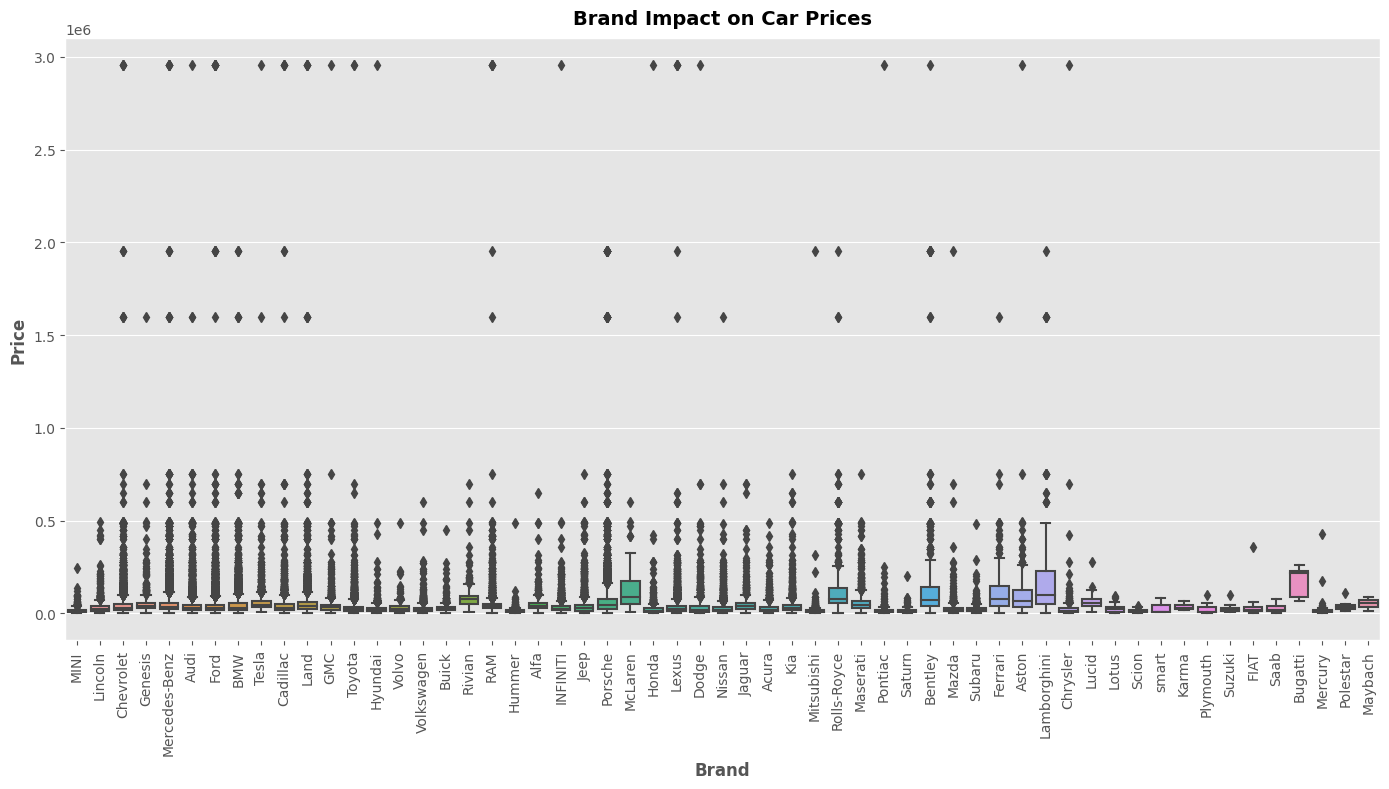

In [13]:
# Box plot for brand vs price
plt.figure(figsize=(14, 8))
sns.boxplot(x='brand', y='price', data=df)
plt.title('Brand Impact on Car Prices')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

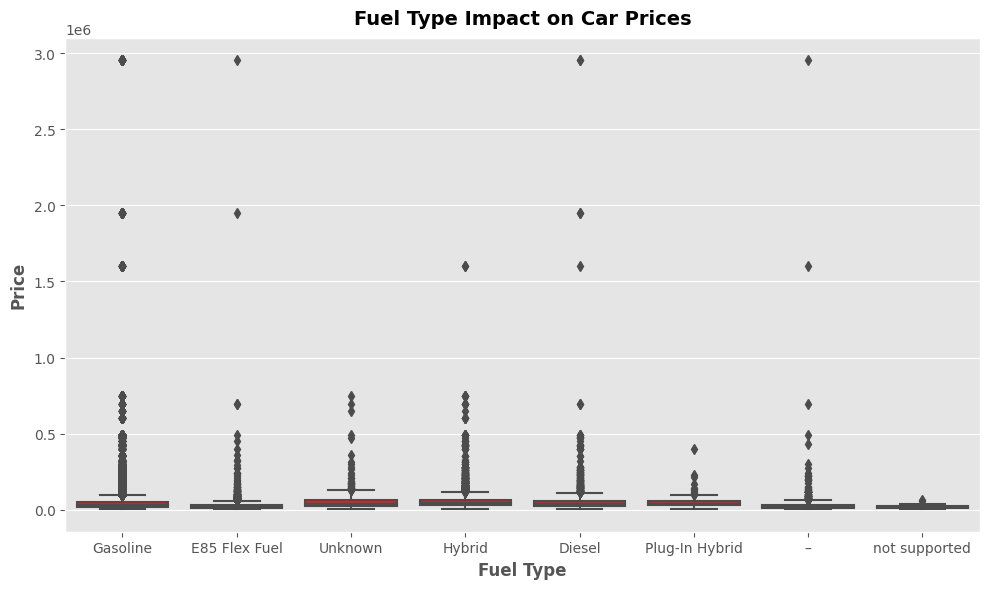

In [14]:
# Box plot for fuel_type vs price
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=df, color='red')
plt.title('Fuel Type Impact on Car Prices')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

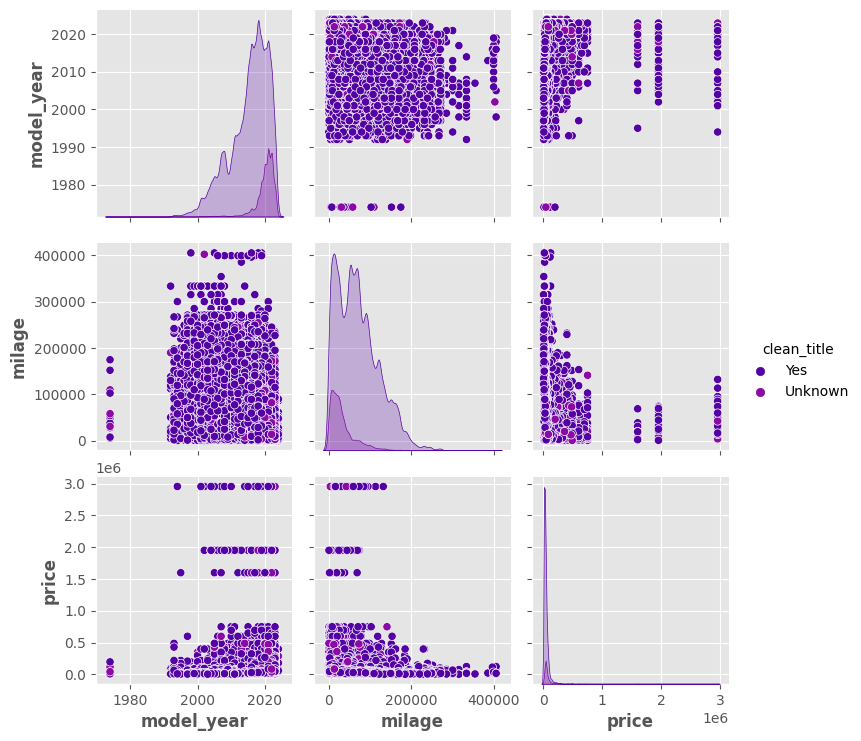

In [15]:
sns.pairplot(df,hue= 'clean_title');

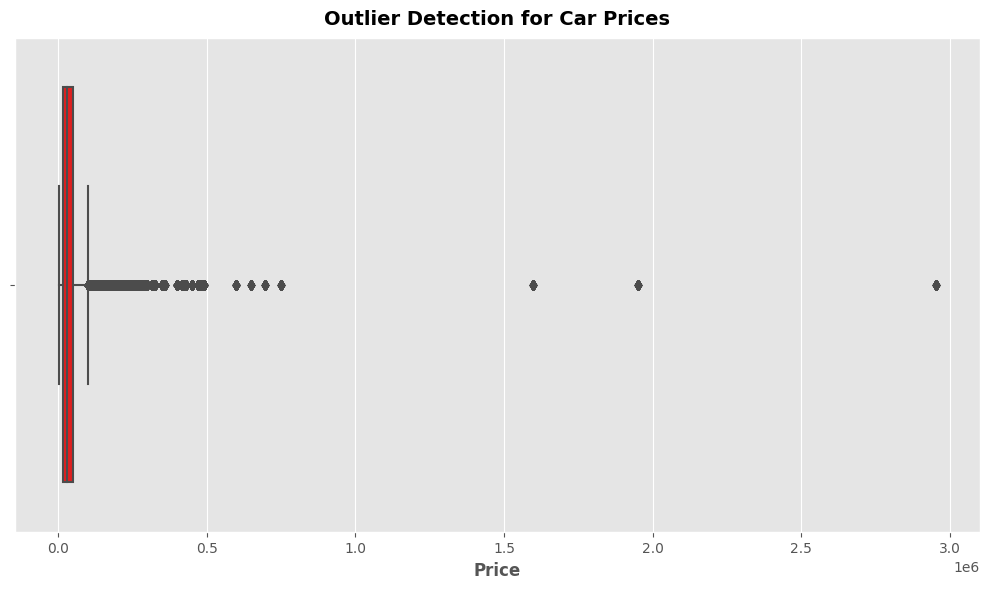

In [16]:
# Box plot to detect outliers in the price variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'], color='red')
plt.title('Outlier Detection for Car Prices')
plt.xlabel('Price')
plt.show()


In [17]:
current_year = datetime.now().year
df['car_age'] = current_year - df['model_year']
df_test['car_age'] = current_year - df_test['model_year']
df.drop('model_year', axis=1, inplace=True)
df_test.drop('model_year', axis=1, inplace=True)

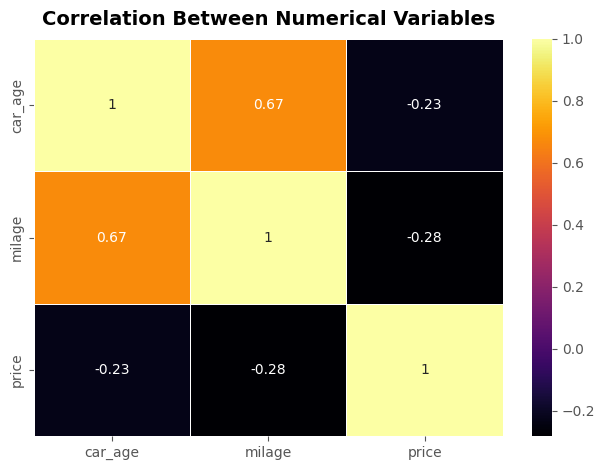

In [18]:
# Correlation heatmap for numerical variables
corr = df[['car_age', 'milage', 'price']].corr()
sns.heatmap(corr, annot=True, cmap='inferno', linewidths=0.5)
plt.title('Correlation Between Numerical Variables')
plt.show()

# Feature Engeering

In [19]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical columns: ", categorical_columns)
print("Numerical columns: ", numerical_columns)
numerical_columns.remove('price')

Categorical columns:  ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical columns:  ['milage', 'price', 'car_age']


In [20]:
print(df.shape)
df.describe(include='O').T

(188533, 12)


,count,unique,top,freq
brand,188533,57,Ford,23088
model,188533,1897,F-150 XLT,2945
fuel_type,188533,8,Gasoline,170142
engine,188533,1117,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,3462
transmission,188533,52,A/T,49904
ext_col,188533,319,Black,48658
int_col,188533,156,Black,107674
accident,188533,3,None reported,146646
clean_title,188533,2,Yes,167114


In [21]:
print(df_test.shape)
#pour voir les valeurs uniques 
df_test.describe(include='O').T

(125690, 11)


,count,unique,top,freq
brand,125690,55,Ford,15265
model,125690,1891,F-150 XLT,1923
fuel_type,125690,8,Gasoline,113173
engine,125690,1117,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,2189
transmission,125690,52,A/T,33132
ext_col,125690,317,Black,32370
int_col,125690,156,Black,71613
accident,125690,3,None reported,97671
clean_title,125690,2,Yes,111451


In [22]:
# Target encoding for 'model'
mean_price_per_model = df.groupby('model')['price'].mean()
df['model'] = df['model'].map(mean_price_per_model)
df_test['model'] = df_test['model'].map(mean_price_per_model)

# Extract engine power and cylinder
df['engine_power'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
df_test['engine_power'] = df_test['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

df['engine_cylinder'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
df_test['engine_cylinder'] = df_test['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)

# Remove the 'engine' column after extraction
df.drop('engine', axis=1, inplace=True)
df_test.drop('engine', axis=1, inplace=True)

# Regroup rare colors in 'ext_col' and 'int_col'
color_threshold = 100  # Adjust the threshold based on the dataset
ext_color_counts = df['ext_col'].value_counts()
rare_ext_colors = ext_color_counts[ext_color_counts < color_threshold].index
df['ext_col'] = df['ext_col'].replace(rare_ext_colors, 'Other')
df_test['ext_col'] = df_test['ext_col'].replace(rare_ext_colors, 'Other')

int_color_counts = df['int_col'].value_counts()
rare_int_colors = int_color_counts[int_color_counts < color_threshold].index
df['int_col'] = df['int_col'].replace(rare_int_colors, 'Other')
df_test['int_col'] = df_test['int_col'].replace(rare_int_colors, 'Other')

# Remove original columns after processing
df.drop(['model', 'ext_col', 'int_col'], axis=1, inplace=True)
df_test.drop(['model', 'ext_col', 'int_col'], axis=1, inplace=True)

# Fill missing engine_power and engine_cylinder with mean values
df['engine_power'].fillna(df['engine_power'].mean(), inplace=True)
df_test['engine_power'].fillna(df_test['engine_power'].mean(), inplace=True)

df['engine_cylinder'].fillna(df['engine_cylinder'].mean(), inplace=True)
df_test['engine_cylinder'].fillna(df_test['engine_cylinder'].mean(), inplace=True)

# Créer de nouvelles features basées sur les interactions
df['milage_car_age'] = df['milage'] * df['car_age']
df['engine_power_car_age'] = df['engine_power'] * df['car_age']

df_test['milage_car_age'] = df_test['milage'] * df_test['car_age']
df_test['engine_power_car_age'] = df_test['engine_power'] * df_test['car_age']


In [23]:
# Separate categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()
# Remove the target from numerical columns
numerical_columns.remove('price')

In [24]:
print( f"Cartegorical columns :\n {categorical_columns}")
print( f"numerical columns :\n {numerical_columns}")

Cartegorical columns :
 ['brand', 'fuel_type', 'transmission', 'accident', 'clean_title']
numerical columns :
 ['milage', 'car_age', 'engine_power', 'engine_cylinder', 'milage_car_age', 'engine_power_car_age']


In [25]:
# Split features and target
X = df.drop(columns=['price']) 
y = df['price']

# Apply RobustScaler to numerical columns
scaler = RobustScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X[categorical_columns], prefix=categorical_columns)
X = pd.concat([X[numerical_columns], X_encoded], axis=1)

# Apply same transformations to test set
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns]) 
df_test_encoded = pd.get_dummies(df_test[categorical_columns], prefix=categorical_columns)
df_test = pd.concat([df_test[numerical_columns], df_test_encoded], axis=1)

# Align columns between train and test
X, df_test = X.align(df_test, join='left', axis=1, fill_value=0)

In [26]:
print( f"X train shape afer encoding {X.shape}")
print( f"df_test  shape afer encoding {df_test.shape}")

X train shape afer encoding (188533, 128)
df_test  shape afer encoding (125690, 128)


# Machine Learning Models

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
models1 = [
    KNeighborsRegressor(), 
    SGDRegressor(max_iter=1000, tol=1e-3), 
    Lasso(), 
    Ridge(), 
    CatBoostRegressor(silent=True), 
    XGBRegressor(), 
    LGBMRegressor(n_estimators=100, max_depth=6)
]

In [30]:
for model in models1:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Model: {model.__class__.__name__}  - RMSE: {rmse}")

Model: KNeighborsRegressor  - RMSE: 75380.71031071589
Model: SGDRegressor  - RMSE: 69144.26176532281
Model: Lasso  - RMSE: 69128.9706856637
Model: Ridge  - RMSE: 69125.77266490525
Model: CatBoostRegressor  - RMSE: 68948.14602854807
Model: XGBRegressor  - RMSE: 70984.10983685727
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 112
[LightGBM] [Info] Start training from score 43890.785316
[LightGBM] [Warning] No further s

In [33]:
modil=LGBMRegressor()

modil.fit(X_train, y_train)
y_test_pred = modil.predict(df_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 112
[LightGBM] [Info] Start training from score 43890.785316


# Submission

In [ ]:
#submission = pd.DataFrame({'id': id_test, 'price': y_test_pred})
#submission.to_csv('submission_9.csv', index=False)

# More Advanced optimisation 

In [ ]:
import optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1.0)
    }
    
    model = LGBMRegressor(**param, random_state=42)
    
    
    model.fit(X_train, y_train) 
    
   
    y_test_pred = model.predict(X_test)
    
    #
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


print("Best hyperparameters:", study.best_params)


best_model = LGBMRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, np.log(y_train))


y_test_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE on Test set with optimized LGBM: {rmse}")


## plot the feature importance and learning curve 

In [35]:
def plot_tree_based_feature_importance_with_learning_curve(model, X_train, y_train, model_name='Tree-Based Model', cv=5):
    """
    Plot feature importance for tree-based models like XGBoost, LightGBM, or CatBoost, and display learning curve.
    
    Parameters:
    - model: The trained model that supports feature_importances_ attribute.
    - X_train: Training data (DataFrame) used for model training (to get feature names).
    - y_train: Target variable for training data.
    - model_name: The name of the model (for title customization).
    - cv: Number of cross-validation folds (default: 5).
    """
    # Plot feature importance if applicable
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        features = X_train.columns

        feature_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='purple')
        plt.title(f'Feature Importance for {model_name}')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"The selected model ({model_name}) doesn't have feature importance attributes.")
    
    # Plot learning curve
    plot_learning_curve(model, X_train, y_train, model_name, cv)

**IF LIKE THE WORK PLEASE LEAVE A COMMENT AND UPVOTE**
